In [1]:
import re  # For regular expressions
import os  # For interacting with the operating system
import sys  # For interacting with the Python interpreter
import math  # For mathematical operations
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from tqdm import tqdm  # For progress bars
import matplotlib.pyplot as plt  # For data visualization
import matplotlib.dates as mdates  # For working with dates
import datetime  # For working with dates and times
import warnings  # For suppressing warnings
from pathlib import PurePath # For file path management
warnings.filterwarnings("ignore")  # Ignore warning messages

## Pre-defined parameters

- **threshold**: Represents the distance parameter used by the wind transpose model (1/2/4 times the experimental area radius).
- **duration**: Denotes the minimum event length in Stanford Defined Events that should be disregarded (30/60/120 seconds).

In [2]:
threshold = 2
duration = 60

## 1. Load Datasets

1. Stanford-Defined Events Dataset (Camera-based): Includes positive events (non-zero release periods) and negative events (zero release periods)
2. Stanford-Defined Events Dataset (Sensor-based):  Contains positive events (non-zero release periods) and negative events (zero release periods)
3. Team-Defined Events Dataset(Camera-based): Categorized with Positive, Negative, and N/A labels for camera-based operators: Andium, Oiler, Kuva
4. Team-Defined Events Dataset(Sensor-based): Categorized with Positive, Negative, and N/A labels for sensor-based operators: Canary, Ecoteco, Qube, Sensirion

In [3]:
# 1. Stanford-Defined Events Dataset(Camera-based)
# which saved in the file: assets/events/PN/candidate_event_duration=60xseconds_[P/N/NA].csv

print("Loading data for camera-based stanford-defined events...")
camera_based_stanford_defined_events_p = pd.read_csv(
    f'../../assets/events_PN/candidate_event_duration={duration}xseconds_P.csv')
camera_based_stanford_defined_events_n = pd.read_csv(
    f'../../assets/events_PN/candidate_event_duration={duration}xseconds_N.csv')
camera_based_stanford_defined_events_na = pd.read_csv(
    f'../../assets/events_PN/candidate_event_duration={duration}xseconds_NA.csv')
print("Loaded data for camera-based stanford-defined events")

# 2. Stanford-Defined Events Dataset(Sensor-based)
# which saved in the file: assets/events/PN/true_event_threshold=2xradius_duration=60xseconds_[P/N/NA].csv

print("Loading data for sensor-based stanford-defined events...")
sensor_based_stanford_defined_events_p = pd.read_csv(
    f'../../assets/events_PN/true_event_threshold={threshold}xradius_duration={duration}xseconds_P.csv')
sensor_based_stanford_defined_events_n = pd.read_csv(
    f'../../assets/events_PN/true_event_threshold={threshold}xradius_duration={duration}xseconds_N.csv')
sensor_based_stanford_defined_events_na = pd.read_csv(
    f'../../assets/events_PN/true_event_threshold={threshold}xradius_duration={duration}xseconds_NA.csv')
print("Loaded data for sensor-based stanford-defined events")


# 3. Team-Defined Events Dataset
# which stored in the file: assets/sensor_data/[sensor_name]_caliddata.csv

sensor_names = [
    "Andium", 
    "Canary",
    "Ecoteco",
    "Kuva",
    "Oiler",
    "Qube",
    "Sensirion"
]

camera_based_sensor_names = [
    "Andium", 
    "Kuva",
    "Oiler"
]
sensor_based_sensor_names = [
    "Canary",
    "Ecoteco",
    "Qube",
    "Sensirion"
]

df_team_defined_events = {}
for sn in sensor_names:
    print("Loading data for sensor: " + sn, end="\t")
    df_team_defined_events[sn] = pd.read_csv(
        '../../assets/sensor_data/' + sn + '_validdata.csv', 
        parse_dates=['EmissionStartDateTime', "EmissionEndDateTime"]
    )[["EmissionStartDateTime", "EmissionEndDateTime", "ReportLabel"]]
    print("Done.")


Loading data for camera-based stanford-defined events...
Loaded data for camera-based stanford-defined events
Loading data for sensor-based stanford-defined events...
Loaded data for sensor-based stanford-defined events
Loading data for sensor: Andium	Done.
Loading data for sensor: Canary	Done.
Loading data for sensor: Ecoteco	Done.
Loading data for sensor: Kuva	Done.
Loading data for sensor: Oiler	Done.
Loading data for sensor: Qube	Done.
Loading data for sensor: Sensirion	Done.


## 2. Overlap-based Filtering and Detection

For each team(both camera-based and sensor-based), perform the following operations:

1. Exclude Stanford-defined events that overlap > 50% with N/A of team defined events
2. Calculate the overlap ratio as follows:
    - Calculate the total overlap ratio between the current Stanford-defined event and all positive events in the overlapped team-defined events, marked as POR (Positive Overlap Ratio)
    - Calculate the total overlap ratio between the current Stanford-defined event and all negative events in the overlapped team-defined events, marked as NOR (Negative Overlap Ratio)
    - Normalize POR and NOR as follows: POR = POR / (POR + NOR), NOR = NOR / (POR + NOR)

3. classifier Stanford-defined events using the following criterias:
    - 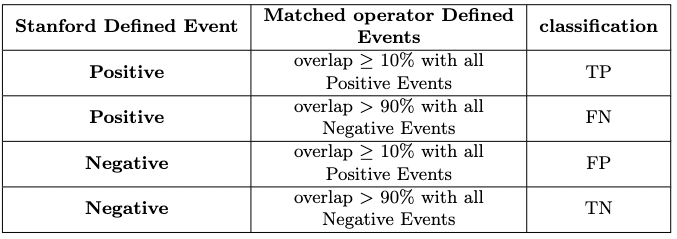

4. calculate detection Metrics for Stanford Defined Events
    - 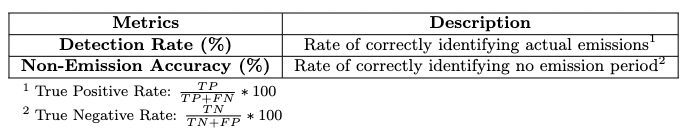 

In [4]:
match_dfs = {
    "Andium": [],
    "Canary": [],
    "Ecoteco": [],
    "Kuva": [],
    "Oiler": [],
    "Qube": [],
    "Sensirion": []
}


for sn in sensor_names:
    print("=" * 20, end="\t")
    print("Processing sensor: " + sn, end="\t")
    print("=" * 20)
    is_camera_based = sn in camera_based_sensor_names
    is_sensor_based = sn in sensor_based_sensor_names    

    team_defined_events = df_team_defined_events[sn]
    if is_camera_based:
        stanford_defined_events_p = camera_based_stanford_defined_events_p
        stanford_defined_events_n = camera_based_stanford_defined_events_n
        stanford_defined_events_na = camera_based_stanford_defined_events_na
    else:
        stanford_defined_events_p = sensor_based_stanford_defined_events_p
        stanford_defined_events_n = sensor_based_stanford_defined_events_n
        stanford_defined_events_na = sensor_based_stanford_defined_events_na

    stanford_defined_events = pd.concat([stanford_defined_events_p, stanford_defined_events_n], axis=0)
    stanford_defined_events = stanford_defined_events.sort_values(by=['ManualStartDateTime']).reset_index(drop=True)

    # calculate overlap ratio of all team-defined events for each stanford-defined event
    for i in range(stanford_defined_events.shape[0]):
        stanford_defined_event = stanford_defined_events.iloc[i]
        stanford_defined_event_start = pd.to_datetime(stanford_defined_event["ManualStartDateTime"])
        stanford_defined_event_end = pd.to_datetime(stanford_defined_event["ManualEndDateTime"])
        stanford_defined_event_date = stanford_defined_event_start.date()
        stanford_defined_event_seconds = (stanford_defined_event_end - stanford_defined_event_start).total_seconds()
        stanford_defined_event_label = stanford_defined_event["Label"]

        if stanford_defined_event_label not in ["P", "N"]:
            continue

        team_defined_events_on_the_same_day = team_defined_events[team_defined_events["EmissionStartDateTime"].dt.date == stanford_defined_event_date]

        overlap_ratio_positive = 0
        overlap_ratio_negative = 0
        overlap_ratio_na = 0

        print("current stanford-defined event: ", stanford_defined_event_start, stanford_defined_event_end, stanford_defined_event_label)
        print("Calculating overlap ratio..", end="\t")
        for j in range(team_defined_events_on_the_same_day.shape[0]):
            team_defined_event = team_defined_events_on_the_same_day.iloc[j]
            team_defined_event_start = pd.to_datetime(team_defined_event["EmissionStartDateTime"])
            team_defined_event_end = pd.to_datetime(team_defined_event["EmissionEndDateTime"])
            team_defined_event_label = team_defined_event["ReportLabel"]

            if team_defined_event_start > stanford_defined_event_end or team_defined_event_end < stanford_defined_event_start:
                continue

            overlap_start = max(team_defined_event_start, stanford_defined_event_start)
            overlap_end = min(team_defined_event_end, stanford_defined_event_end)
            overlap_duration = (overlap_end - overlap_start).total_seconds() / stanford_defined_event_seconds

            if team_defined_event_label == "P":
                overlap_ratio_positive += overlap_duration
            elif team_defined_event_label == "N":
                overlap_ratio_negative += overlap_duration
            else:
                overlap_ratio_na += overlap_duration
        print("Done.", end="\t")
        print(f"overlap_ratio_positive: {overlap_ratio_positive}, overlap_ratio_negative: {overlap_ratio_negative}, overlap_ratio_na: {overlap_ratio_na}")
        if overlap_ratio_positive + overlap_ratio_negative == 0:
            print(f"A stanford-defined event({stanford_defined_event_start}, {stanford_defined_event_end})" + \
                  "does not overlap with any team-defined events, ignore it.")
            continue
        print("Classifying stanford-defined event..", end="\t")
        if overlap_ratio_na > 0.5:
            print(f"A stanford-defined event({stanford_defined_event_start}, {stanford_defined_event_end})" + \
                  "overlaps with more than 50% of NA events, ignore it.")
            continue
        else:
            POR = overlap_ratio_positive / (overlap_ratio_positive + overlap_ratio_negative)
            NOR = overlap_ratio_negative / (overlap_ratio_positive + overlap_ratio_negative)
            if stanford_defined_event_label == "P" and POR >= 0.1:
                stanford_defined_event_class = "TP"
            if stanford_defined_event_label == "P" and POR < 0.1:
                stanford_defined_event_class = "FN"
            if stanford_defined_event_label == "N" and POR >= 0.1:
                stanford_defined_event_class = "FP"
            if stanford_defined_event_label == "N" and POR < 0.1:
                stanford_defined_event_class = "TN"

            match_dfs[sn].append([
                sn, stanford_defined_event_class, stanford_defined_event_label, stanford_defined_event_start, stanford_defined_event_end, POR, NOR
            ])
        print("Done.", end="\t")
        print("Classification result: ", stanford_defined_event_class)

# transform list to dataframe
for sn in sensor_names:
    match_dfs[sn] = pd.DataFrame(data=match_dfs[sn], columns=["sensor", "label", "EventClass", "EventStart", "EventEnd", "POR", "NOR"])

====================	Processing sensor: Andium	====================
current stanford-defined event:  2022-10-10 00:00:00 2022-10-10 16:42:28 N
Calculating overlap ratio..	Done.	overlap_ratio_positive: 0, overlap_ratio_negative: 0, overlap_ratio_na: 0
A stanford-defined event(2022-10-10 00:00:00, 2022-10-10 16:42:28)does not overlap with any team-defined events, ignore it.
current stanford-defined event:  2022-10-10 17:00:01 2022-10-10 17:03:27 P
Calculating overlap ratio..	Done.	overlap_ratio_positive: 1.0, overlap_ratio_negative: 0, overlap_ratio_na: 0
Classifying stanford-defined event..	Done.	Classification result:  TP
current stanford-defined event:  2022-10-10 17:30:14 2022-10-10 17:43:30 P
Calculating overlap ratio..	Done.	overlap_ratio_positive: 1.0, overlap_ratio_negative: 0, overlap_ratio_na: 0
Classifying stanford-defined event..	Done.	Classification result:  TP
current stanford-defined event:  2022-10-10 17:43:31 2022-10-10 17:46:09 N
Calculating overlap ratio..	Done.	overla

In [5]:
# calculate detection Metrics for Stanford Defined Events
metrics = []
metrics_name = ["Detection Rate (%)", "Non-Emission Accuracy (%)"]
print("Calculating detection metrics..")
for sn in sensor_names:

    print("Processing sensor: " + sn, end="\t")
    n_tp = match_dfs[sn][match_dfs[sn]["label"] == "TP"].shape[0]
    n_fn = match_dfs[sn][match_dfs[sn]["label"] == "FN"].shape[0]

    n_fp = match_dfs[sn][match_dfs[sn]["label"] == "FP"].shape[0]
    n_tn = match_dfs[sn][match_dfs[sn]["label"] == "TN"].shape[0]

    detection_rate_percent = n_tp / (n_tp + n_fn) * 100
    non_emission_accuracy_percent = n_tn / (n_tn + n_fp) * 100
    print("Done.", end="\t")
    print(f"Detection Rate(%): {detection_rate_percent}, Non-Emission Accuracy(%): {non_emission_accuracy_percent}")
    metrics.append([sn, detection_rate_percent, non_emission_accuracy_percent])

Calculating detection metrics..
Processing sensor: Andium	Done.	Detection Rate(%): 62.55506607929515, Non-Emission Accuracy(%): 87.24832214765101
Processing sensor: Canary	Done.	Detection Rate(%): 95.0, Non-Emission Accuracy(%): 49.056603773584904
Processing sensor: Ecoteco	Done.	Detection Rate(%): 25.609756097560975, Non-Emission Accuracy(%): 95.14563106796116
Processing sensor: Kuva	Done.	Detection Rate(%): 91.9431279620853, Non-Emission Accuracy(%): 73.63636363636363
Processing sensor: Oiler	Done.	Detection Rate(%): 69.91869918699187, Non-Emission Accuracy(%): 92.85714285714286
Processing sensor: Qube	Done.	Detection Rate(%): 75.0, Non-Emission Accuracy(%): 74.24242424242425
Processing sensor: Sensirion	Done.	Detection Rate(%): 89.7196261682243, Non-Emission Accuracy(%): 54.109589041095894


## 3. Save Results

In [6]:
root_path = PurePath("../../results/03_DetectionAnalysis/Event-based ConfusionMatrix/Stanford Defined Events_Reliability")

# save detection metrics to csv file
metrics_df = pd.DataFrame(data=metrics, columns=["sensor", "Detection Rate (%)", "Non-Emission Accuracy (%)"])
metrics_df.to_csv(root_path / f"threshold={threshold}xradius_duration={duration}xseconds.csv", index=False)

# save match events to csv file
root_path = PurePath("../../results/03_DetectionAnalysis/Test-case Matching Data/Stanford Defined Events")
for sn in sensor_names:
    match_dfs[sn].to_csv(root_path / f"{threshold}xradius_{duration}xseconds_{sn}_match_events.csv", index=False)